In [505]:
# Filename: QML_Python_Worksheet_solution.ipynb
# Authors: Felipe Ixcamparic, Subadra Echeverria, M. Cerezo
# Date: November 3, 2021
# Description: First python exercice sheet.
# Note: Unfortunately, github does not support inline latex equations, thus, the latex equations are NOT displayed correctly here. 
#       For an easy fix, download the notebook and open it on google collab.

In [792]:
#
#    Notas finales: 
#    Muchas gracias a Marco Cerezo y Subadra Echeverría por su ayuda en el curso, así como la forma en que lo impartieron. También a los organizadores del evento PWF2021
#    
#    Muchas gracias también a todxs lxs estudiantes del curso PWF 2021, fue un gusto ser auxiliar de ustedes y espero de veras que éste código les sea de utilidad
#
#    En este notebook se encuentran las soluciones al curso PWF2021 en español, así como generalizaciones útiles para el uso de machine learning en computadoras cuánticas. 
#
#    La QCNN todavía necesita ser generalizada para n qubits con n capas, espero en el futuro poder realizar esto, de lo contrario es el único paso que 
#    el usuario debe jugar para dar con una QCNN óptima con este tipo de Ansatz. 
#
#    Es posible realizar esto con mediciones y posteriormente implementar ruido, de momento, utiliza qi.Statevector para extraer el statevector de cada circuito, 
#    pero eso no niega que se pueda realizar con mediciones tanto en simmulación como en Computadoras Cuánticas. 
#    
#

#    
#    Exitos. 


# QML Python Worksheet

by M. Cerezo, Felipe Ixcamparic, Subadra Echeverria

This set of exercises is aimed at introducing the basic tools that will be later used for a Quantum Machine Learning (QML) implementation. 

We refer the reader to the [Qiskit webpage](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html) for further details.

## Getting started

First thing's first. Lets install some packages we will use.

In [1]:
!pip install qiskit
!pip install pylatexenc

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import *
from IPython.display import Image
from IPython.core.display import HTML 

## Hello World of Quantum Circuits

Here we will show how to use the basics of Qiskit. 

In [3]:
# Create a Quantum Circuit acting on a quantum register of two qubits
qcirc = QuantumCircuit(2)

We want to write the circuit that prepares a Bell pair.

In [4]:
# Add a H gate on qubit 0, putting this qubit in superposition.
qcirc.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
qcirc.cx(0, 1)

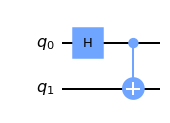

In [5]:
# We can visualize the circuit
qcirc.draw()

Qiskit has a function called `statevector_simulator' which prints the quantum state obtained at the output of the circuit.

In [6]:
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

# Create a Quantum Program for execution
job = backend.run(qcirc)
result = job.result()
outputstate = result.get_statevector(qcirc, decimals=10)
print(outputstate)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


We can also simulate quantum measurements. For this purpose, we need to add measurements to the original circuit above, and use a different Aer backend.

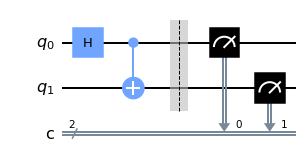

In [7]:
# Create a Quantum Circuit with 2 quantum registers and 2 classical registers
meas = QuantumCircuit(2, 2)
meas.barrier(range(2))
# map the quantum measurement to the classical bits
meas.measure(range(2), range(2))

# The Qiskit circuit object supports composition using the addition operator.
qcirc.add_register(meas.cregs[0])
qc = qcirc.compose(meas)

#drawing the circuit
qc.draw()

In [8]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator. We've set the number of repeats of the circuit to be 1024, which is the default.
N_shots=1024
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N_shots)

# Grab the results from the job.
result_sim = job_sim.result()

In [9]:
# We can print the measurement outcomes and the probability of each outcome
counts = result_sim.get_counts(qc)
print(counts)
probability={}
for ele in counts:
  probability[ele]=counts[ele]/N_shots
print(probability)

{'00': 525, '11': 499}
{'00': 0.5126953125, '11': 0.4873046875}


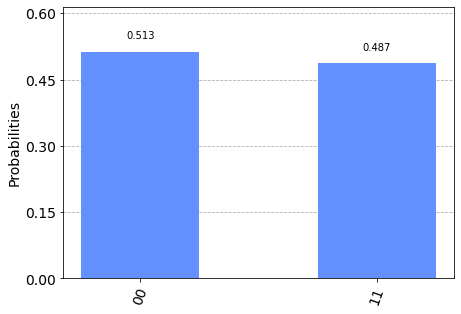

In [10]:
# And we can visualize them
plot_histogram(counts)

**Note**: This representation of the bitstring puts the most significant bit (MSB) in the left, and the least significant bit (LSB) on the right. This is the standard ordering of binary bitstrings. We order the qubits in the same way (qubit representing the MSB has index 0), which is why Qiskit uses a non-standard tensor product order.

We can double-check that the error in those probabilities are within the statistical uncertainty of order $1/\sqrt{N}$. Here $N=1024$. We recall that this uncertainty tells us that $p(i)=N_i/N\pm 1/\sqrt{N}$, where $N_i$ is the probability of the $i$-th outcome.

In [11]:
statistical_error=1/N_shots**.5
print(statistical_error)

0.03125


We can also check that the measurement outcomes are correct by using the  `statevector_simulator' and computing $p(00)=\text{Tr}[M_{00} \rho]$, with $\rho=|\psi\rangle\langle\psi|$.

Here, we use $M_{00}=|0\rangle\langle 0|\otimes|0\rangle\langle 0|=\begin{pmatrix}1&0\\0&0\end{pmatrix}\otimes \begin{pmatrix}1&0\\0&0\end{pmatrix}=\begin{pmatrix}1&0&0&0\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{pmatrix}$.

In [12]:
M00=np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
rho=np.outer(outputstate, outputstate.conj())
p00=np.trace(np.matmul(M00,rho))
print(p00)

(0.5000000000190247+0j)


We can also create a circuit where we only measure one qubit.


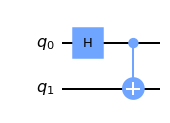

In [13]:
# Create a Quantum Circuit acting on a quantum register of two qubits
qcirc2 = QuantumCircuit(2)
qcirc2.h(0)
qcirc2.cx(0, 1)
qcirc2.draw()

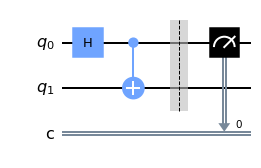

In [14]:
# Create a Quantum Circuit with 2 quantum registers and 1 classical registers
meas2 = QuantumCircuit(2, 1)
meas2.barrier(range(2))
# map the quantum measurement to the classical bits
meas2.measure(0, 0)

# The Qiskit circuit object supports composition using the addition operator.
qcirc2.add_register(meas2.cregs[0])
qc2 = qcirc2.compose(meas2)

#drawing the circuit
qc2.draw()

These are the measurement outcomes.

In [15]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator. We've set the number of repeats of the circuit to be 1024, which is the default.
N_shots=1024
job_sim = backend_sim.run(transpile(qc2, backend_sim), shots=N_shots)

# Grab the results from the job.
result_sim = job_sim.result()

# We can print the measurement outcomes and the probability of each outcome
counts = result_sim.get_counts(qc2)
print(counts)
probability={}
for ele in counts:
  probability[ele]=counts[ele]/N_shots
print(probability)

{'1': 518, '0': 506}
{'1': 0.505859375, '0': 0.494140625}


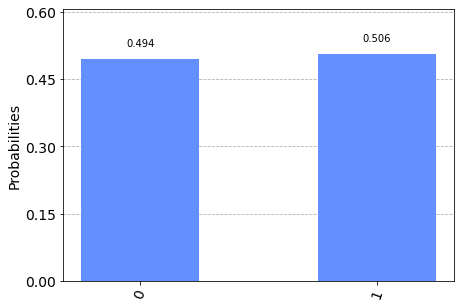

In [16]:
# And we can visualize them
plot_histogram(counts)

We can double check that the measurement outcomes are correct by using the  `statevector_simulator' and computing $p_A(0)=\text{Tr}[(M_{0}\otimes I_B) \rho]$, with $\rho=|\psi\rangle\langle\psi|$.

Note that due to qiskit's qubit ordering convention, we need to build the kronecker product with different qubit ordering.

Here, we use $(M_{0}\otimes I_B)=\begin{pmatrix}1&0\\0&1\end{pmatrix}\otimes \begin{pmatrix}1&0\\0&0\end{pmatrix}=\begin{pmatrix}1&0&0&0\\0&0&0&0\\0&0&1&0\\0&0&0&0\end{pmatrix}$.

In [17]:
M00=np.array([[1,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
rho=np.outer(outputstate, outputstate.conj())
p00=np.trace(np.matmul(M00,rho))
print(p00)

(0.5000000000190247+0j)


## Quantum Operations

You can find a summary of Qiskit's quantum operations [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb).

For now, let us create a single qubit state that is rotated about the $Y$-axis on an angle $\theta$.

In [18]:
def rotation_Y(quantum_circuit,theta)-> None:
  '''
    Applying a rotation about the Y axis to a single qubit

    Parameters
    ----------
    quantum_circuit: QuantumCircuit
      The quantum cirquit to which we apply ansatz
    theta: float
        The parameters for the R_y gate

  '''
  quantum_circuit.ry(theta,0)

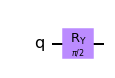

In [19]:
# We set theta=pi/2
qcirc3 = QuantumCircuit(1)
rotation_Y(qcirc3,np.pi/2)
qcirc3.draw()

We denote as $|\psi(\theta)\rangle=R_y(\theta)|0\rangle$ the otput state from the previous circuit.

### Computing expectation values.

Here we will compute the expectation value of the $Z$ operator over a single qubit quantum state.

In [20]:
# First, let us define the Z-Pauli operator
Z=np.array([[1,0],[0,-1]])
print(Z)

#We can also import it from qiskit as 



print(qi.Pauli('Z').to_matrix())

[[ 1  0]
 [ 0 -1]]
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


**Exercice 1:** 

Use the statevector_simulator backend to compute the expectation value of $Z$ as a function of $\theta$. Here, use  matrix multiplication to compute $\langle Z\rangle=\langle\psi(\theta)|Z|\psi(\theta)\rangle$. Make a plot of $\langle Z\rangle$ versus $\theta$.




In [21]:
# Solution to Exercice 1:
def expectz(theta):
    '''
    Hallando un valor de expectación para Z con circuitos de 1 solo qubit
    por medio de 'statevector_simulator'

    Parametros
    ----------
   theta: float
        Parametros para la compuerta ry. 

  '''
      
    #Es posible utilizar los operadores de Pauli con qi.   
    
    Z=qi.Pauli('Z').to_matrix()
    
    
    #Se genera un circuito para aplicarle la rotación en y. 
    
    a = QuantumCircuit(1) 
    rotation_Y(a,theta)  #Puede usarse también a.ry(theta, a)
    
     
    #Se llama al simulador para obtener su statevector      
    # Se puede usar también qi.Statevector(a) o Statevector.from_instruction(a).__array__() si se desea. 
    
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(a)
    result = job.result()
    psi_theta = result.get_statevector(a, decimals=10)       
    
    
    #Se almacena el valor de expectación               
    
    expect_z=np.vdot( psi_theta, np.matmul(Z,psi_theta ) )
    
    return expect_z.real

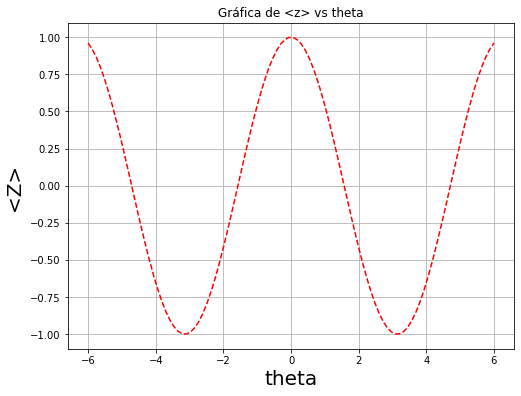

In [22]:
#Ploteo de los valores de theta vs <Z>

#Se generan valores de theta y almacenan los valores de su valor de expectación. 
theta_vals= np.linspace(-6,6,100)

expected_vals=[]
for i in range(0,100):
    expected_vals.append(expectz(theta_vals[i]))
    
#Se grafican los valores almacenados utilizando matplotlib 

fig=plt.figure(figsize=(8, 6))
plt.plot(theta_vals,expected_vals,'r--')
plt.xlabel("theta",size=20)
plt.ylabel("<Z> ",size=20)
# plt.axvline(x=np.pi, color='b', linestyle='-')     #Descomentar si desean ver los máximos o mínimos
# plt.axvline(x=-np.pi, color='b', linestyle='-')
# plt.axvline(x=0, color='g', linestyle='-')
plt.title("Gráfica de <z> vs theta")
plt.grid()
plt.savefig('expectz')
fig.show()

**Exercice 2:**

Simulate measurements to compute the expectation value of $Z$ as a function of $\theta$.

In [23]:
# Solution to Exercice 2:

from qiskit import IBMQ
def expectz_counts(theta):
      
#         '''
#     Hallando un valor de expectación para Z con circuitos de 1 solo qubit
#     por medio de 'qasm_simulator'

#     Parametros
#     ----------
#    theta: float
#         Parametros para la compuerta ry. 

#   '''    
    
    ##Se mantiene la estructura inicial de la función anterior 
    
    Z=qi.Pauli('Z').to_matrix()   
    a = QuantumCircuit(1,1) 
    a.ry(theta,0)
    a.measure(0,0)     #Se añade la medición, midiendo el qubit hacia su bit clásico correspondiente. 
    
    
    
    ##Ahora podemos extraer las probabilidades como vimos antes al momento de realizar mediciones (es practicamente copiar el bloque de código y adaptarlo) 

###Descomentar si se quiere correr en una QC 
#     provider = IBMQ.load_account()
#     provider = IBMQ.get_provider('ibm-q')
#     qcomp= provider.get_backend('ibmq_quito') #En este caso se corre en la computadora cuántica 

#     job_qcomp = execute(a, backend=qcomp,shots=1024)
#     counts=job_qcomp.result().get_counts(a)
    
    backend_sim = Aer.get_backend('qasm_simulator')
    N_shots=1024
    job_sim = backend_sim.run(transpile(a, backend_sim), shots=N_shots)

    result_sim = job_sim.result()

    counts = result_sim.get_counts(a)
    
    
    #Se almacenan las probabilidades en un diccionario 
    
    probability={}
    for ele in counts:
          probability[ele]=counts[ele]/N_shots

    """ como paso final solo es necesario obtener los elementos del diccionario y encontrar <Z>   """        
    p_0= probability.get('0')
    if p_0==None:
        p_0=0
        
    p_1= probability.get('1')
    zexpectation= p_0-p_1
    return p_0-p_1

## First Variational Quantum Algorithm

From the previous, we see that it is very easy to verify that $\langle Z\rangle$ is minimized for $\theta=-\pi$. However, we want to solve this problem numerically. First, we load an optimizer.

In [24]:
# Load an optimization package
from scipy.optimize import minimize

**Exercice 3:** 
Define a cost function $C(\theta)$ that takes as input a parameter $\theta$ and outputs $\langle\psi(\theta)|Z|\psi(\theta)\rangle$.

In [32]:
# Solution to Exercice 3:
def cost_function(theta):
       
    #Es posible utilizar los operadores de Pauli con qi.   
    
    Z=qi.Pauli('Z').to_matrix()
    
    
    #Se genera un circuito para aplicarle la rotación en y. 
    
    a = QuantumCircuit(1) 
    rotation_Y(a,theta)  #Puede usarse también a.ry(theta, a)
    
     
    #Se llama al simulador para obtener su statevector      
    # Se puede usar también qi.Statevector(a) o Statevector.from_instruction(a).__array__() si se desea. 
    
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(a)
    result = job.result()
    psi_theta = result.get_statevector(a, decimals=10)       
    
    
    #Se almacena el valor de expectación               
    
    expect_z=np.vdot( psi_theta, np.matmul(Z,psi_theta ) )
    cost_function_values.append(expect_z.real)
    return expect_z.real

In [595]:
## We can optimize the cost function using the minimize function.
cost_function_values=[]
# First, we set a random parameter to start the optimziation
t0 = np.random.rand() * 10 * np.pi
# t0=3
# We then run the optimization using the COBYLA method, with a maximum of 300 iteration steps
out = minimize(cost_function, t0, method="COBYLA", options={'maxiter':20})

In [596]:
out.x

array(9.42497842)

**Exercice 4:** 
Verify that the optimization finds the correct solution of $\theta=-\pi\,\, \text{mod}(2\pi)$.

In [597]:
float("{0:.2f}".format(out.x%(2*np.pi))) == float("{0:.2f}".format(np.pi))

True

**Exercice 5:** 
Plot the cost function value versus iteration step.

Tip: define an empty array `cost_function_values = [ ]` and add a line to the cost function that appends cost value to the previous array: `cost_function_values.append( )`.

In [599]:
# Solution to Exercice 5:
cost_function_values=[]
minimize(cost_function, t0, method="COBYLA", options={'maxiter':100})

     fun: -0.9999999951228675
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array(9.42467842)

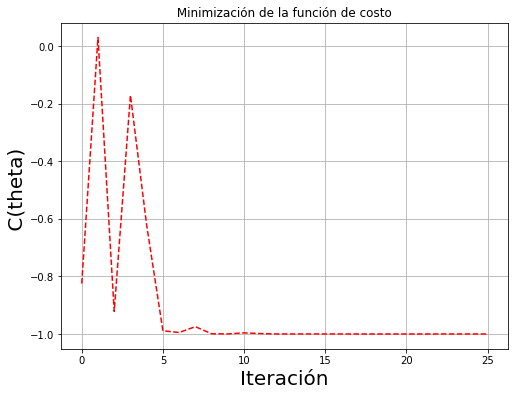

In [600]:
fig=plt.figure(figsize=(8, 6))
plt.plot(cost_function_values,'r--')
plt.xlabel("Iteración",size=20)
plt.ylabel(" C(theta)  ",size=20)
plt.title(" Minimización de la función de costo ")
plt.grid()
fig.show()  

## Second Variational Quantum Algorithm

Here we implement a variational algorithm in two qubits.

In [569]:
# First, let us define a two qubit gate that we will use as a basis for the parametrized two qubit circuit.

def two_qubit_gate(quantum_circuit,parameters,q0,q1)-> None:
  '''
    Applying a rotation about the Y axis to a single qubit

    Parameters
    ----------
    quantum_circuit: QuantumCircuit
      The quantum cirquit to which we apply ansatz
    parameters: float
        The parameters for the rotations 
    q1: int
      first qubit that the gate acts on
    q2: int
      second qubit that the gate acts on

  '''
  quantum_circuit.ry(parameters[0],q0)
  quantum_circuit.ry(parameters[1],q1)
  quantum_circuit.cx(q0,q1)
  quantum_circuit.ry(parameters[2],q0)
  quantum_circuit.ry(parameters[3],q1)


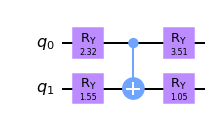

In [570]:
# Here we show the action of the two-qubit gate with 4 random angles
random_parameters = np.random.rand(4) * 2 * np.pi
qcirc4 = QuantumCircuit(2)
two_qubit_gate(qcirc4,random_parameters,0,1)
qcirc4.draw()

**Exercice 6:** 
If we apply two layers of the `two_qubit_gate unitary` we will have a redundancy of two Ry gates acting one after the other. How can we remove this parameter redundancy?

In [572]:
#Para no caer en la redundancia se puede declarar una función (IMPORTANTE PARA EL RESTO DEL NOTEBOOK)
# que aplique las capas de la siguiente forma 
def two_qubit_layer(quantum_circuit,parameters,q0,q1)-> None:
    '''
        un cx, seguido de rotación en los qubits implicados

        Parametros
        ----------
        quantum_circuit: QuantumCircuit
          The quantum cirquit to which we apply ansatz
        parameters: float
            The parameters for the rotations 
        q1: int
          first qubit that the gate acts on
        q2: int
          second qubit that the gate acts on

  '''
    quantum_circuit.cx(q0,q1)
    quantum_circuit.ry(parameters[0],q0)
    quantum_circuit.ry(parameters[1],q1)

In [625]:
#Removedor de parametros, se utilizará luego de que se aplique cada layer. 
def para_remover(parameters,n):
    '''
        Removedor de parámetros para un array o lista
        
        Parametros
        ----------
        parameters: list o np.array, float
          parámetros de rotación 
        q1: int
          primer qubit en donde actúa la compuerta
        q2: int
          segundo qubit donde actúa la compuerta 
        
        Return
        --------
        parameters: list o np.array, float
            parámetros reducidos. 
    '''
    for i in range(n):
        parameters= np.delete(parameters,0)
        
    return parameters

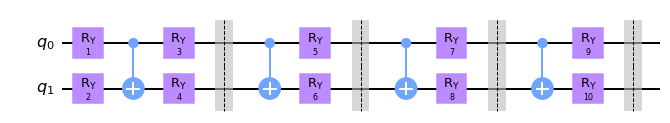

In [618]:
# Solution to Exercice 6:

#Es entonces que podemos generalizar nuestro circuito de 2 qubits hacia un número n de capas

def circ2qubs(parameters,layers):
    '''
        Ansatz de 2 qubits con n capas 
        
        Parametros
        ----------
        parameters: list o np.array, float
          parámetros de rotación 
        layers: int
          número de capas en el circuito 
        
        Return
        --------
        qcirc4: QuantumCircuit
            Circuito cuántico generado 
        statevec: array,float,real
            Statevector obtenido del circuito cuántico
    '''     
    
    #Se genera el circuito 
    qcirc4 = QuantumCircuit(2)
    
    ##Condición inicial 
    
    two_qubit_gate(qcirc4,parameters,0,1)
    parameters= para_remover(parameters,4)   #Siempre iremos removiendo valores de nuestro vector dinámico 
    qcirc4.barrier(range(2))    
    
    
    ##Capas siguientes 
    for i in range(layers):
        two_qubit_layer(qcirc4,parameters,0,1)
        parameters=para_remover(parameters,2)
        qcirc4.barrier(range(2))
   
    statevec= qi.Statevector(qcirc4).__array__()
        
    return qcirc4, statevec


#Testeamos la función 
parametros=np.linspace(1,10,10)
circ2qubs(parametros ,3)[0].draw()

**Exercice 7:**

Write cost functions that minimize the expectation values $\langle Z\otimes Z\rangle$ and $\langle X\otimes I\rangle$.

In [582]:
# Solution to Exercice 7:

##Definición de funciones para los valores de expectación
vals_expectzz=[]
vals_expectxi=[]

def expectzz(parameters): 
    
    #Se encuentran explícitamente los valores de expectación 
    
    ZZ = qi.Pauli('ZZ').to_matrix()
    statevec = circ2qubs(parameters,3)[1]
    expect_z= np.vdot( statevec, np.matmul(ZZ,statevec))
    vals_expectzz.append(expect_z.real) #Descomentar si se quiere ver la gráfica, no es necesario tenerlo siempre activado
    return expect_z.real

def expectxi(parameters): 
    #Se hallan explícitamente sus valores de expectación y se retornan 
    XI = qi.Pauli('XI').to_matrix()
    statevec= circ2qubs(parameters,3)[1]
    expect_xi= np.vdot(statevec, np.matmul(XI,statevec))
    vals_expectxi.append(expect_xi.real) #Descomentar si se quiere ver la gráfica, no es necesario tenerlo siempre activado
    return expect_xi.real    

In [583]:
#Minimización: 

## Minimización de ZZ

# First, we set a random parameter to start the optimziation
t0 =np.random.rand(10)*2*np.pi

# We then run the optimization using the COBYLA method, with a maximum of 300 iteration steps
out = minimize(expectzz, t0, method="COBYLA", options={'maxiter':300})


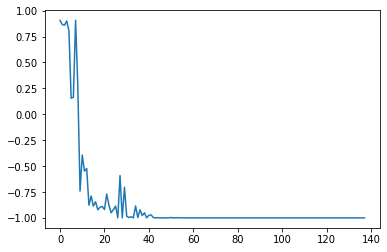

In [584]:
plt.plot(vals_expectzz)


In [585]:
#Minimización: 

## Minimización de XX

# First, we set a random parameter to start the optimziation
t0 =np.random.rand(10)*2*np.pi

# We then run the optimization using the COBYLA method, with a maximum of 300 iteration steps
out = minimize(expectxi, t0, method="COBYLA", options={'maxiter':300})

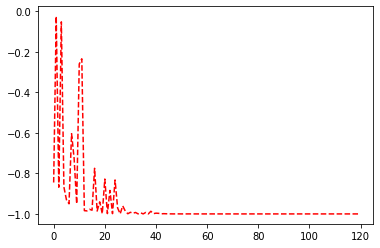

In [557]:
plt.plot(vals_expectxi,'r--')

## The Ising Model
The Ising model is a well-known condensed matter model that describes ferromagnetism in statistical mechanics. At its core, it describes interactions between spins in the systems and the interactions between the spins and an external magnetic field.

The Hamiltonian of the model is

$H=-\sum_{i=1}^{n-1} X_i\otimes X_{i+1}-g\sum_{i=1}^n Z_i$.

Here, the terms $X_i\otimes X_{i+1}$ describe the spin-spin interaction, while $Z_i$ is the interaction between the spins and a magnetic field along the $z$ direction. 

This ground states of this model have a `phase transition` at $g=1$, such that for $g\leq 1$ the states are paramegnetic, while for $g\geq 1$ they are ferromagnetic.

**Exercice 8:**

Explicitly write the matrix for the Hamiltonian $H$ of the Ising model for $n=2,4,6$ spins. Then, make a plot of the eigenvalues of $H$ as a function of $g$. What happens at $g=1$?

In [45]:
# Solution to Exercice 8:
#Declaramos explícitamente nuestros Hamiltonianos para 2,4 6 qubits. 

def H2qubs(g):
    X_12=qi.Pauli('XX').to_matrix()
    Z_1=qi.Pauli('ZI').to_matrix()
    Z_2=qi.Pauli('IZ').to_matrix()
    H= -X_12 - g*(Z_1+Z_2)
    autval= np.min(np.linalg.eigvals(H))
    return autval.real,H

def H4qubs(g):
    X_12=qi.Pauli('XXII').to_matrix()
    X_23=qi.Pauli('IXXI').to_matrix()
    X_34=qi.Pauli('IIXX').to_matrix()
    
    
    Z_1=qi.Pauli('ZIII').to_matrix()
    Z_2=qi.Pauli('IZII').to_matrix()
    Z_3=qi.Pauli('IIZI').to_matrix()
    Z_4=qi.Pauli('IIIZ').to_matrix()
    
    
    H= -(X_12+X_23+X_34)  - g*(Z_1+Z_2+Z_3+Z_4)
    autval= np.min(np.linalg.eigvals(H))
    return autval.real,H

def H6qubs(g):
    X_12=qi.Pauli('XXIIII').to_matrix()
    X_23=qi.Pauli('IXXIII').to_matrix()
    X_34=qi.Pauli('IIXXII').to_matrix()
    X_45=qi.Pauli('IIIXXI').to_matrix()
    X_56=qi.Pauli('IIIIXX').to_matrix()
    
    
    Z_1=qi.Pauli('ZIIIII').to_matrix()
    Z_2=qi.Pauli('IZIIII').to_matrix()
    Z_3=qi.Pauli('IIZIII').to_matrix()
    Z_4=qi.Pauli('IIIZII').to_matrix()
    Z_5=qi.Pauli('IIIIZI').to_matrix()
    Z_6=qi.Pauli('IIIIIZ').to_matrix()
    
    
    
    H= -(X_12+X_23+X_34+X_45+X_56)- g*(Z_1+Z_2+Z_3+Z_4+Z_5+Z_6)
    autval= np.min(np.linalg.eigvals(H))
    return autval.real,H

In [647]:
##Es posible realizar una generalización para n qubits
def Hamiltonian(qubits,g): 
    '''
        Hamiltoniano de Ising para n qubits 
        
        Parametros
        ----------
        qubits: int
          número de qubits para el Hamiltoniano de Ising
        g: float
          constante g correspondiente al hamiltoniano
        
        Return
        --------
        autovalor mnimo: float
            autaovalor mínimo correspondiente al Hamiltoniano de Ising 
        Hamil: matriz con el Hamiltoniano de Ising correspondiente

    '''

    Hamil=0
    
    #Se generan strings para ingresarlos luego en su respectivo qi.Pauli(''). 
    for i in range(1,qubits):
        #Identidades previas al qubit
        Xtest=['']
        Ztest=['']
        for j in range(1,i):
            Xtest[0]=Xtest[0]+'I'
            Ztest[0]=Ztest[0]+'I'
         
        #Interacción a pares y única de cada qubits agregada
        Xtest[0]=Xtest[0]+'XX'
        Ztest[0]=Ztest[0]+'Z'
        
        #Identidades necesarias para completar la dimensión en XX como en Z
        for w in range(i+2,qubits+1):
            Xtest[0]=Xtest[0]+'I'
            
        for ww in range(i+1,qubits+1):
            Ztest[0]=Ztest[0]+'I'
            
            
        #Se suma cada parte hacia la matriz del Hamiltoniano    
        Hamil= Hamil+ -qi.Pauli(Xtest[0]).to_matrix() -g* qi.Pauli(Ztest[0]).to_matrix()
        
        # print(Xtest)   #Debugging
        # print(Ztest)
        
    Ztest=['']     #Se vacía el vector correspondiente a Z 
    
    #Se añade el último valor que falta en Z 
    for i in range(1,qubits):
            Ztest[0]= Ztest[0]+'I'
    Ztest[0] = Ztest[0]+'Z'
    Hamil= Hamil-g* qi.Pauli(Ztest[0]).to_matrix()
 
    
    return np.min(np.linalg.eigvals(Hamil)).real,Hamil


#Se puede testear claro:
Hamiltonian(10,0.4)

(-9.485963801552401,
 array([[-4. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j, -3.2+0.j, -1. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [ 0. +0.j, -1. +0.j, -3.2+0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        ...,
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  3.2+0.j, -1. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ..., -1. +0.j,  3.2+0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  4. +0.j]]))

In [648]:
#Se grafican los distintos Hamiltonianos para visualizar los valroes de energía correspondiente a los 
#estados fundamentales
ges=np.linspace(-2,2,50)
H2_vals=[]
H4_vals=[]
H6_vals=[]
for i in range(50):
    H2_vals.append(H2qubs(ges[i])[0])
    H4_vals.append(H4qubs(ges[i])[0])
    H6_vals.append(H6qubs(ges[i])[0])

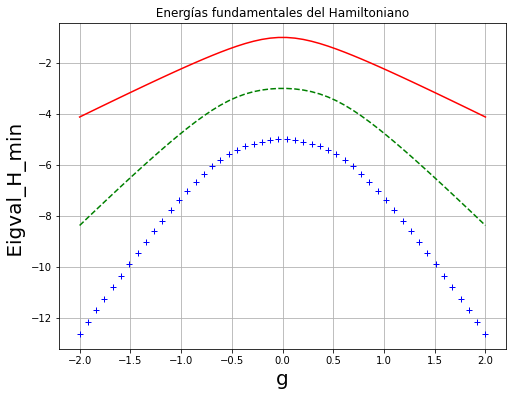

In [649]:
fig=plt.figure(figsize=(8, 6))
plt.plot(ges,H2_vals,'r-',label='q=2')
plt.plot(ges,H4_vals,'g--',label='q=4')
plt.plot(ges,H6_vals,'b+',label='q=6')
plt.xlabel("g",size=20)
plt.ylabel(" Eigval_H_min  ",size=20)
plt.title(" Energías fundamentales del Hamiltoniano ")
plt.grid()
fig.show()   

**Exercice 9:**

Create a Variational Quantum Eigensolver (VQE) algorithm that finds the ground state of $H$ for $g=.25,.5,1.25,1.5$ (for $n=4$ or $n=6$).

For this purpose, first create a layered ansatz as the one shown bellow.

In [608]:
Image(url= "https://entangledphysics.files.wordpress.com/2021/11/ansatz.png")

Here, $R_y$ are rotations about the $y$ axis (with independent angles). We show an ansatz with 3 layers.

[-0.14323728+0.j -0.03336521+0.j  0.08314928+0.j -0.06940041+0.j
  0.25355614+0.j  0.16629664+0.j  0.02697608+0.j  0.01307912+0.j
  0.16872867+0.j  0.01366952+0.j  0.21104011+0.j -0.06785156+0.j
  0.68968949+0.j  0.32760133+0.j  0.30836559+0.j -0.34338612+0.j]


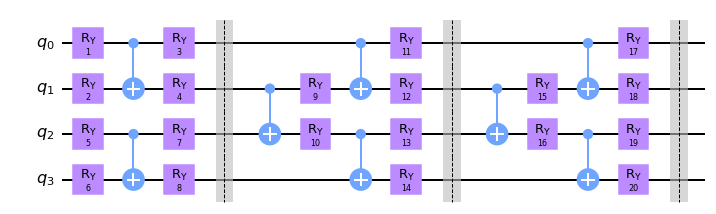

In [650]:
# Solution to Exercice 9:


#Paso 1: Crear el ansatz para n_capas 

#Definamos un circuito para 4 qubits entonces
def circ4qubs(parameters,layers):
        '''
        Ansatz de 4 qubits con n capas 
        
        Parametros
        ----------
        parameters: list o np.array, float
          parámetros de rotación 
        layers: int
          número de capas en el circuito 
        
        Return
        --------
        qcirc4: QuantumCircuit
            Circuito cuántico generado 
        statevec: array,float,real
            Statevector obtenido del circuito cuántico
        '''


        qcirc4 = QuantumCircuit(4)
        
        for i in range(0,4,2):
            two_qubit_gate(qcirc4,parameters,i,i+1)
            parameters= para_remover(parameters,4)

        qcirc4.barrier(range(4))

        for i in range(layers-1):
            
            two_qubit_layer(qcirc4,parameters,1,2)
            parameters= para_remover(parameters,2)


            two_qubit_layer(qcirc4,parameters,0,1)
            parameters= para_remover(parameters,2)

            two_qubit_layer(qcirc4,parameters,2,3)
            parameters= para_remover(parameters,2)
            qcirc4.barrier(range(4))
        statevec= qi.Statevector(qcirc4).__array__()

        return qcirc4,statevec
    
    
para=np.linspace(1,20,20)
print(circ4qubs(para,3)[1])
circ4qubs(para,3)[0].draw()

Como siempre recordemos que nuestra función de costo para este caso será: $C(\theta)= <\psi (\theta) | H | \psi(\theta) >$

In [651]:
#Paso 2: Definir la función de costo sabiendo nuestro Hamiltoniano para 4 qubits

g=0.25
cost_4qubs_values=[]
#Definiendo la función de costo para 4 qubits
def cost_function_4qubs(parameters):
        statevec= circ4qubs(parameters,8)[1]
        Hamil= H4qubs(g)
        cost_4qubs_values.append(np.vdot(statevec, np.matmul(Hamil[1], statevec )).real)
        return np.vdot(statevec, np.matmul(Hamil[1], statevec )).real

cost_function_4qubs(np.random.rand(50)*2*np.pi)

0.15235196816390045

In [652]:
#Paso 3 : Minimizar la función de costo 

cost_4qubs_values=[]
t0 =np.random.rand(50)*2*np.pi

# We then run the optimization using the COBYLA method, with a maximum of 300 iteration steps
out = minimize(cost_function_4qubs, t0, method="COBYLA", options={'maxiter':400})


In [653]:
print("El error absoluto entre el valor teórico y nuestra minimización es "+ str ((H4qubs(0.25)[0]-out.fun)/H4qubs(0.25)[0]*100)+ str("%"))

El error absoluto entre el valor teórico y nuestra minimización es 0.27119373738737507%


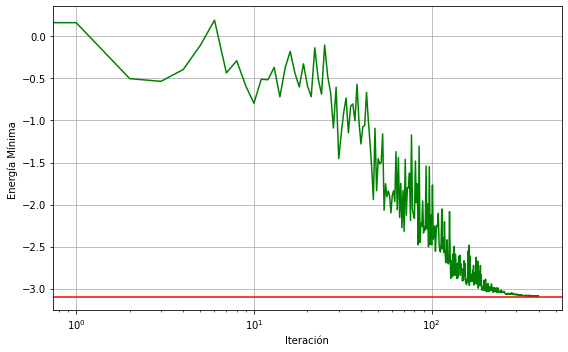

In [654]:
#Paso 4: Verificar que el número de iteracioens hagan que nuestra función de costo converja al autovalor mínimo del Hamiltoniano

fig=plt.figure(figsize=(8, 5))
plt.plot(cost_4qubs_values,'g')
plt.xlabel("Iteración",size=10)
plt.ylabel("Energía Mínima ",size=10)
plt.xscale("log")

plt.axhline(y=H4qubs(0.25)[0], color='r', linestyle='-')
plt.tight_layout()
plt.grid()
fig.show()

## A Quantum Dataset
The Ising model provides a perfect way to create a dataset for quantum machine learning. Specifically, we will here create a supervised learning task of clasfifying states according go the phase of matter they belong to.

As previously mentioned, the ground states of the Ising model are paramagnetic for $g\leq 1$, and ferromagnetic for $g\geq 1$.

As shown in the figure below, this allows us to create a dataset of ground states $|\psi_i\rangle$ belonging to the either the paramagnetic of ferromagnetic phase.

In [183]:
Image(url="https://entangledphysics.files.wordpress.com/2021/11/qml.png")

**Exercice 10:**

Randomly sample 30 fields $g$ in each phase and run VQE algorithms to create a dataset of $60$ ground states of the Ising model (for $n=6$). 

[Note: Check that VQE outputs the correct states! We want a high quality dataset. You can do this by only accepting VQE solutions that are within an error of 0.01 from the true value.]

We will divide this data into 2 sets:

A training set of $40$ states, and a testing set of $20$ states.

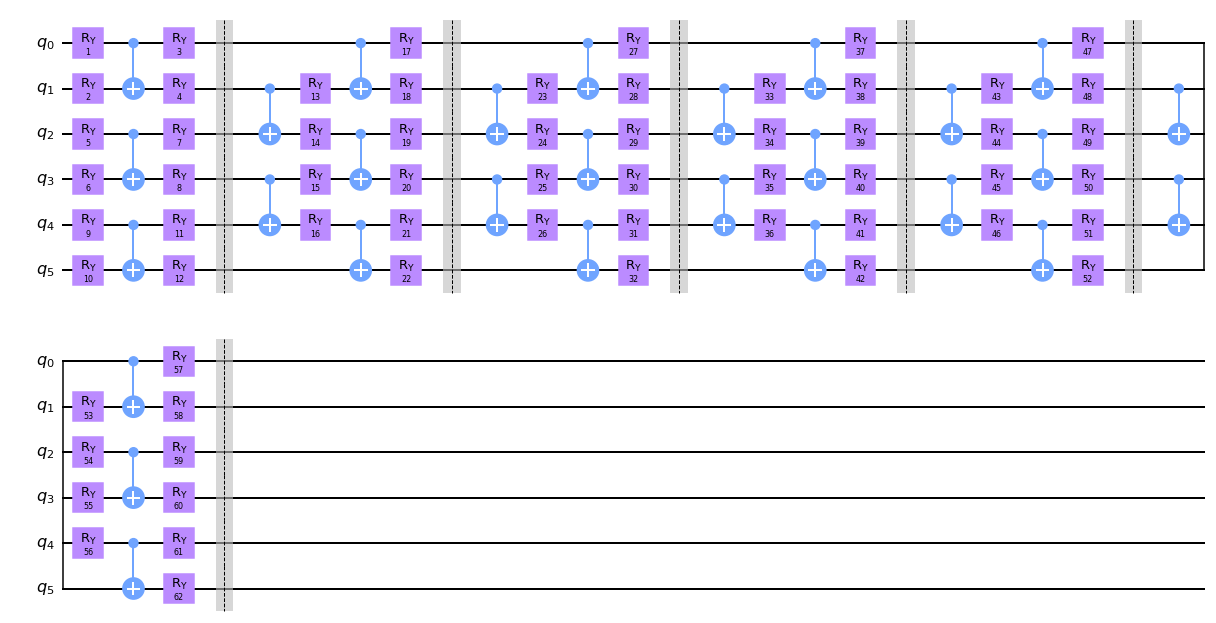

In [662]:
#Como regalo,les dejaré la función para n_qubits, con n capas sin gastar parámetros: 
def circ_nqubs(parameters,qubits,layers):
        '''
        Ansatz de n qubits con n capas 
        
        Parametros
        ----------
        parameters: list o np.array, float
          parámetros de rotación
          
        qubits: int
            número de qubits en el circuito
        layers: int
          número de capas en el circuito 
        
        Return
        --------
        qcirc4: QuantumCircuit
            Circuito cuántico generado 
        statevec: array,float,real
            Statevector obtenido del circuito cuántico
        '''

        qcirc4 = QuantumCircuit(qubits)
    ##Caso de qubits impares 
        #Capa inicial
                
        if qubits%2==1:
            qubits=qubits-1
            for i in range(0,qubits,2):
                two_qubit_gate(qcirc4,parameters,i,i+1) 
                parameters= para_remover(parameters,4)
    
            qcirc4.ry(parameters[0],qubits)
            parameters= para_remover(parameters,1)
            qcirc4.barrier(range(qubits+1))
            
        #Capas siguientes:  
            flag=0         #Bandera para alternar entre extremos y medios (por defecto empieza en medios) 
            for i in range(0,layers*2-2):
                
                if flag==0:
                     
                    for j in range(0,qubits,2):
                        two_qubit_layer(qcirc4,parameters,j+1,j+2)
                        parameters= para_remover(parameters,2)
                    flag=1
                else:
                    for j in range(0,qubits,2):
                        two_qubit_layer(qcirc4,parameters,j,j+1)
                        parameters= para_remover(parameters,2)
                    qcirc4.barrier(range(qubits+1))  
                    flag=0
                       
        
        
     
    ##Caso de qubits pares  
        
        #Condición inicial 
        else:
                for i in range(0,qubits,2):
                    two_qubit_gate(qcirc4,parameters,i,i+1) 
                    parameters= para_remover(parameters,4)
                qcirc4.barrier(range(qubits))
       
        
        #Capas siguientes:  
                flag=0      #Condición para alternar entre centros y extremos (empieza en centros) 
                for i in range(0,layers*2-2):
        
                    if flag==0:
                        for j in range(0,qubits-2,2):
                            two_qubit_layer(qcirc4,parameters,j+1,j+2)
                            parameters= para_remover(parameters,2)
                        flag=1
                    else:
                        for j in range(0,qubits,2):
                            two_qubit_layer(qcirc4,parameters,j,j+1)
                            parameters= para_remover(parameters,2)

                        flag=0
                        qcirc4.barrier(range(qubits)) 
         
       
        statevec= qi.Statevector(qcirc4).__array__()

        return qcirc4,statevec
    
circ_nqubs(np.linspace(1,62,62),6,6)[0].draw()

In [698]:
#Se puede hacer también una cost_function para n qubits
cost_func_nqubs_vals=[]
def cost_function_nqubs(parameters): 
    '''
    Función de costo para n qubits

    Parametros
    ===========
        Locales
        --------
            parameters: np.array,list ; float
                parametros respectivos al circuito a generar. 
        Globales
        --------
            qubits: int
                numero de qubits correspondientes al modelo de Ising buscado
            layers: int
                número de capas correspondientes al circuito a generar. 
            g: float
                constante g para el Hamiltoniano de Ising que se desee simlar 
    
    Salida:
    ---------
    cost_val: float
        valor de la función de costo. 
    

    '''
    statevec= circ_nqubs(parameters,qubits,layers)[1]
    Hamilr=Hamiltonian(qubits,g)[1]
    cost_val= np.vdot(statevec, np.matmul( Hamilr,statevec )).real
    cost_func_nqubs_vals.append(cost_val)
    
    return cost_val

In [699]:
#Definamos nuestra minimización como otra función: 
def minimization(cost_function, t_0,maxitr):
    '''
    Minimización de una función de costo

    Parametros
    ----------
    cost_function: float
      función de costo a minimizar
    t_0: np.array,list; float
        parámetros iniciales a evaluar en la minimización
    
    Salidas:
    ---------
    salida.fun: float
        valor minimizado de la función de costo
    salida.x: np.array, list ; float
        lista de parámetros minimizados 
    

    '''
    salida = minimize(cost_function, t_0, method="COBYLA", options={'maxiter':maxitr})
    return salida.fun, salida.x    

In [69]:
#Antes de utilizar todas las generalizaciones que tenemos hasta ahora, crearemos por última vez el caso para 
# 6 qubits explícitamente 

params6qubs=[]  #No ovidemos siempre agregar nuestro vector dinámico para verificar la convergencia al valor mínimo 
def cost_function_6qubs(parameters):
        statevec= circ_nqubs(parameters,6,6)[1]  #6 qubits, parametros y 6 capas. 
        Hamilr= H6qubs(g)
        params6qubs.append(np.vdot(statevec, np.matmul( H6qubs(g)[1],statevec )).real)
        return np.vdot(statevec, np.matmul( H6qubs(g)[1],statevec )).real

In [692]:
##Minimización con 6 qubits especificamente 
#Condiciones iniciales (Pueden jugar con ellas) 

t_0 =np.random.rand(62)*2*np.pi
maxitr=500
g=1.3
params6qubs=[]
val= minimization(cost_function_6qubs, t_0,maxitr)[0]

print((H6qubs(g)[0]-val)/H6qubs(g)[0])

0.036588252365132905


In [700]:
## Minimización usando las funciones generales: 

# Condiciones iniciales (pueden jugar con ellas, a partir de aquí pueden hacerlo para n qubits,
#  n capas, cualquier valor de g, cualquier valo de iteracioens y sus parámetros.
#--------------------------------------
maxitr=500
qubits=6
layers=6
g=1.3
t_0 =np.random.rand(62)*2*np.pi
cost_func_nqubs_vals=[]
#---------------------------------------

val=  minimization(cost_function_nqubs, t_0,maxitr)[0]

print((Hamiltonian(qubits,g)[0]-val)/Hamiltonian(qubits,g)[0])

0.04498731030150915


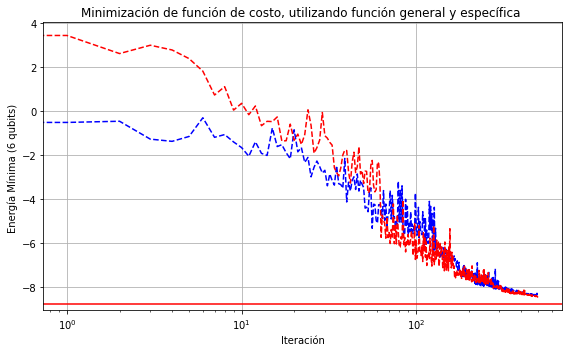

In [701]:
#Pueden plotear si gustan para ver el número óptimo de iteraciones (no usen demasiadas a menos que quieran saturar su ram) 
fig=plt.figure(figsize=(8, 5))
plt.plot(cost_func_nqubs_vals,'b--',label='cost_funct_nqubs (6,6)')
plt.plot(params6qubs,'r--',label='cost_funct_6qubs')
plt.xlabel("Iteración",size=10)
plt.ylabel("Energía Mínima (6 qubits) ",size=10)
plt.title("Minimización de función de costo, utilizando función general y específica ")
plt.xscale("log")

plt.axhline(y=Hamiltonian(qubits,g)[0], color='r', linestyle='-')
plt.grid()
plt.tight_layout()
fig.show()

In [793]:
# Solution to Exercice 10:
'''
Extracción de dataset para el modelo de Ising con cualquier configuración: 
    
    Para la extracción basta con correr las funciones destacas con descripcion:
        circ_nqubs()
        Hamiltonian()
        cost_function_nqubs()
        minimization()


    Basta con mover las condiciones iniciales para la extracción del dataset. La complejidad
    computacional no ha sido tomada aún para este proceso, por lo que se recomienda paciencia mas que todo
    y RAM. 
    

'''


##Con todo lo anterior es relativamente sencillo extraer un dataset, para ello abriremos archivos de texto:

#===================================================================================================
#Condiciones iniciales
num=60      #Número de datos a extraer
maxitr=400   #Número de iteraciones en cada minimización
qubits=6      # Número de qubits
layers=6     #Número de capas
n_parameters=62      #Número de parámetros correspondientes a los qubits y capas (revisar el circuito antes) 

#nombre de archivos de texto
ges_name='gesvalsv.txt'
params_name='paramsvalsv.txt'
cost_name='costvalsv.txt'
#=========================================================================================================

#Apertura de archivos de texto
f1 = open(ges_name, "w")
f2 = open(params_name,"w")
f3 = open(cost_name,"w")

#Proceso de guardado en archivo
for i in range(0,num):
        t_0=np.random.rand(n_parameters)*2*np.pi   #Para este caso de 6 qubs con 6 capas se necesitan 62 parámetros. 
        g=np.random.uniform()*2          #Generamos un nuevo valor para g

   
        en_min,parameterss= minimization(cost_function_nqubs, t_0,maxitr)


        if  (Hamiltonian(qubits,g)[0]- en_min)/Hamiltonian(qubits,g)[0] <= 0.08:
            #Escritura en los archivos de texto
            f1.write(str("{0:.10f}".format(g)))  #Redacción de parámetros g en el primer archivo de texto
            f1.write("\n")
            f3.write(str("{0:.10f}".format(cost_function_nqubs(parameterss))))  #Redacción de parámetros g en el primer archivo de texto
            f3.write("\n")

            with open(params_name, "ab") as f:        #Escritura de parámetros theta en el segundo archivo de texto
                np.savetxt(f, parameterss)

f1.close()
f2.close()
f3.close()

In [749]:
#Es posible entonces cargar los documentos guardados con parámetros
gestotal=np.loadtxt("gesvalsv.txt")
costotal=np.loadtxt("costvalsv.txt")
paramstotal = np.loadtxt("paramsvalsv.txt")
paramstotal= np.reshape(paramstotal,(len(gestotal),n_parameters))  #Se hace un reshape para almacenarlo en una matriz y así trabajar mas facilmente con los params

H_teo_vals=[]
for i in range(len(gestotal)):
    H_teo_vals.append(Hamiltonian(qubits,gestotal[i])[0])

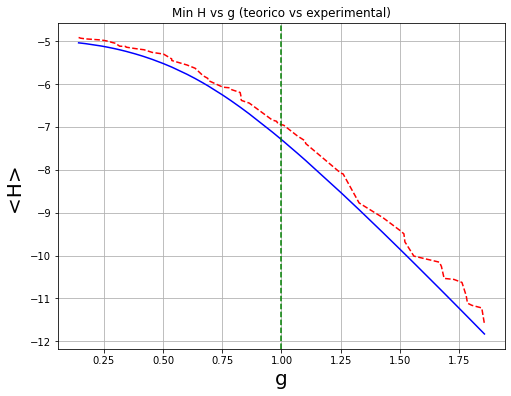

In [750]:
#Se reordenan los datos y se grafican para ver que tan cerca estamos de los valores teóricos 


gestotal_vals=np.sort(gestotal)
H_teo_vals=np.sort(H_teo_vals)[::-1]
costotal=np.sort(costotal)[::-1]




fig=plt.figure(figsize=(8, 6))
plt.plot(gestotal_vals,costotal,'r--')
plt.plot(gestotal_vals,H_teo_vals,'b-')
plt.xlabel("g",size=20)
plt.ylabel("<H> ",size=20)
plt.title("Min H vs g (teorico vs experimental)")
plt.axvline(x=1, color='g', linestyle='--')
plt.grid()
fig.show()   


Once we have the dataset, we can send the states trough a Quantum Neural Network that will learn to classify them. In this case, we will use a Quantum Convolutional Neural Network (QCNN). Below we show a QCNN for 4 qubits.

In [65]:
Image(url="https://entangledphysics.files.wordpress.com/2021/11/qcnn.png ")

**Exercice 11:**

Write a code for the QCNN ansatz.

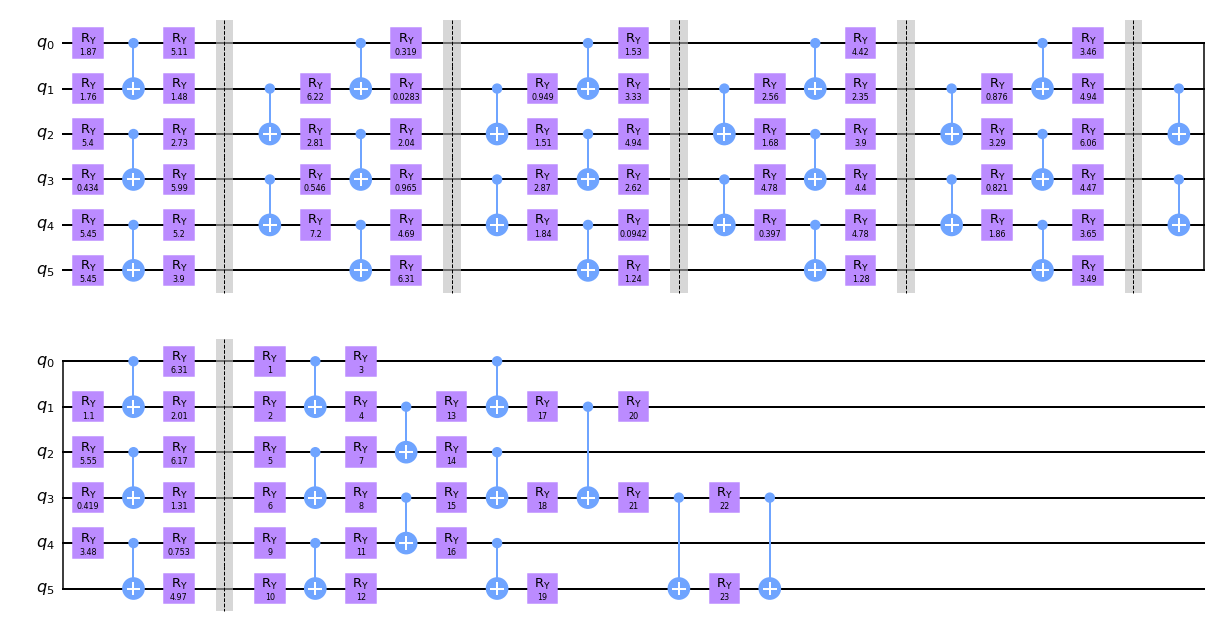

In [734]:
# Solution to Exercice 11:

def qcnn(qcirc,alphas):
        '''
        Rotaciones necesarias para la red convolusional cuántic a:

            Esta funcion aplica rotaciones sobre un conjunto de parámetros
            correspondiente a un VQE de 6 qubits con 6 capas, es posible realizar una generalización
            pero aún no ha sido implementada. La función retorna el objeto del circuito y su statevector

        Parametros:
        -----------
            qcirc:  QuantumCircuit. 
                Circuito cuántico donde se aplicarán las rotaciones 
            alphas: np.array o list; float
                parámetros alpha a implementar (deben ser 24 para este caso)
            params: np.array o list ; float
                parámetros correspondientes al circuito del VQE
        Salida:
        -------

        ''' 
        
        for i in range(0,6,2):
            two_qubit_gate(qcirc,alphas,i,i+1)
            for i in range(4):
                    alphas= np.delete(alphas,0)                 

         
        for i in range(0,4,2):
            two_qubit_layer(qcirc,alphas,i+1,i+2)
            for i in range(2):
                    alphas= np.delete(alphas,0) 

        for i in range(0,6,2):
            qcirc.cx(i,i+1)

        for i in range(1,6):
            if i%2==1:
                qcirc.ry(alphas[0],i)
                alphas= np.delete(alphas,0) 

        
        for i in range(1,4,2):
            two_qubit_layer(qcirc,alphas,i,i+2)
            for i in range(2):
                alphas= np.delete(alphas,0)
            
        qcirc.cx(3,5)
        
        statevec= qi.Statevector(qcirc).__array__()
        return qcirc,statevec

qcnn(circ_nqubs(paramstotal[0],6,6)[0],np.linspace(1,60,60))[0].draw()

The way in which we assign labels is by measuring the expectation value of the Pauli $Z$ operator on the output single-qubit state of the QCNN $\rho_i(\alpha)=\text{Tr}_{trash}[|\psi(\alpha)\rangle\langle\psi(\alpha)|]$, where $\alpha$ are the trainable parameters in the QCNN, $|\psi(\alpha)\rangle$ the full state at the output of the QCNN, and $trash$ the subset of qubits that are not measured. In the picture above, $|\psi(\alpha)\rangle$ is a pure state on four qubits and $\rho_i(\alpha)$ is the reduced state on the bottom qubit.

That is, the assigned label is $\widetilde{y}_i(\alpha)=\text{Tr}[\rho_i(\alpha)Z]$.

Note that, one can always compute this expectation value (using qiskit inverse kronecker product notation) as 

$\widetilde{y}_i(\alpha)=\text{Tr}[|\psi_i(\alpha)\rangle\langle \psi_i(\alpha)|(Z\otimes I\otimes I\otimes I)]=\langle \psi_i(\alpha)|(Z\otimes I\otimes I\otimes I)|\psi_i(\alpha)\rangle$.

And we train the mean-squared error loss function:
$\mathcal{L}(\alpha)=\frac{1}{40}\sum_{i=1}^{40}(\widetilde{y}_i(\alpha)-y_i)^2$.

In [751]:
#Se llena nuestro label y_i con los valores que teníamos g_i según se ha indicado anteriormente
y_i = []
for i in range(0,len(gestotal)):
    if gestotal[i] > 1 :
        y_i.append(1)
    elif gestotal[i] < 1:
        y_i.append(-1)

In [752]:
#Se define una función para almacenar las etiquetas correspondientes a  <Z> de cada circuito 

def ylabel(statevec):
    return np.vdot( statevec, np.matmul(  qi.Pauli('ZIIIII'),statevec)).real  #No olvidar la conveniencia de notación en qiskit. 

statevectest= qcnn(circ_nqubs(paramstotal[12],6,6)[0],np.linspace(1,60,60))[1]

ylabel(statevectest)

-0.20448947199141387

In [753]:
ele_vals=[]

#Declaramos nuestra loss function en función de los parámetros alpha. 
def Ele(alphas): 
    ele=0 
    #Se realiza la sumatoria para los mínimos cuadrados entre los labels esperados con su contraparte practica
    
    for i in range(40): #Solo hará 40 porque utilizaremos este número de datos para el training 
        val_i= ylabel(qcnn(circ_nqubs(paramstotal[i],6,6)[0],alphas)[1])
        ele = ele + (val_i-y_i[i])**2
    ele = ele/40
    # print(ele)
    ele_vals.append(ele)
    return ele   
                             

#Se comprueba que funcione     
alphas=np.linspace(1,24,24) 
print(Ele(alphas))                             

0.8391207035619465


In [754]:
#Proceso de minimización: 
    #Optimizamos la red neuronal (QCNN) como siempre se ha venido haciendo, el número de iteraciones queda a decisión del usuario 

t_0 =np.random.rand(23)*2*np.pi
maxitr=20  #Noté que por las 100 iteraciones ya comienza a converger de una forma menos errática
ele_vals=[]
alphasoptimized= minimization(Ele,t_0,maxitr)

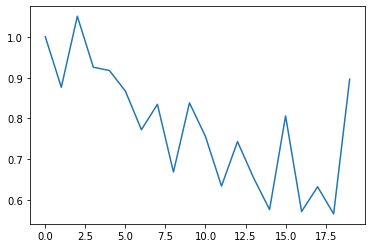

In [755]:
plt.plot(ele_vals)

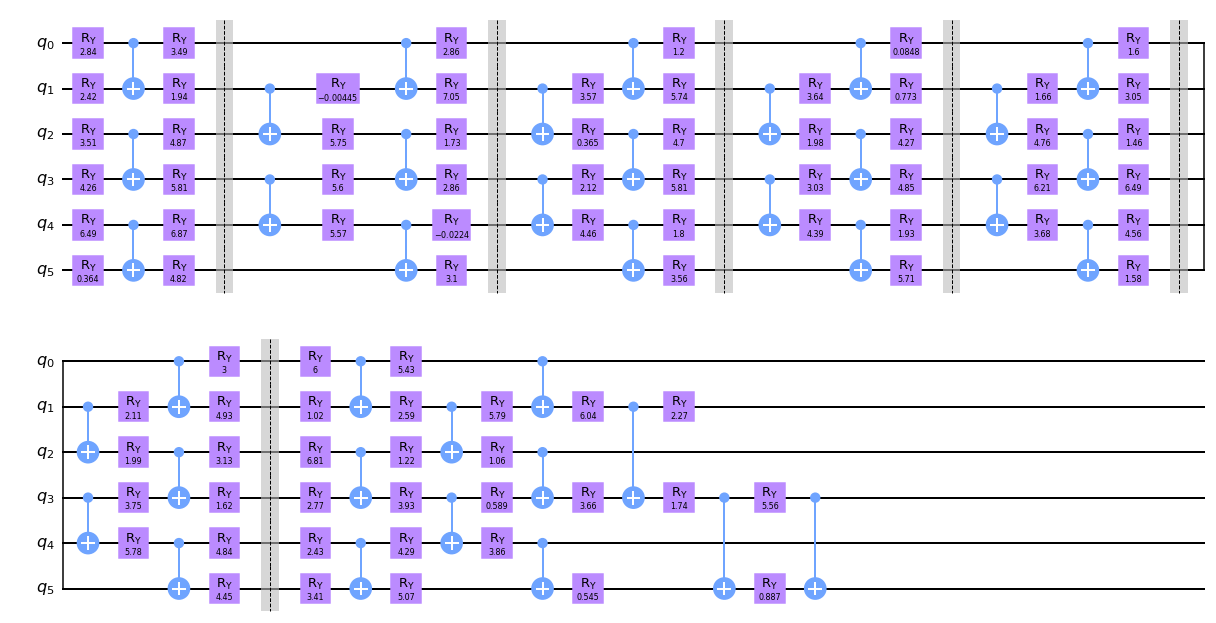

In [756]:
qcnn(circ_nqubs(paramstotal[0],6,6)[0],alphasoptimized[1])[0].draw()

**Exercice 12:**

Train the QCNN to classify quantum states according to the phase of matter that they belong to.

Once we have trained the QCNN, we need to test its accurancy in clasifying. However, the expectation values previously computed are continous numbers in $[-1,1]$, while the true labels are discrete values in the set $\{-1,1\}$.

In order to assing a discrete label to each state, we need a discretizing function. For instance, this can be achieved by

$\widehat{y}_i=1$ if $\widetilde{y}_i(\alpha)\geq 0$, 

and 

$\widehat{y}_i=-1$ if $\widetilde{y}_i(\alpha)< 0$.

Given this discretization, we can now use the $20$ states in the testing set  to check how many of the assigned labels $\widehat{y}_i$ match with the true labels $y_i$.

**Exercice 13:**

Compute the percentage of correct label assignment on the testing set.

In [764]:
qubits=6
layers=6

In [775]:
###Chequeemos primero el training para saber que nuestra red se adaptó de buena forma con nuestros datos: 

# Solution to Exercice 13:
n_total=len(gestotal)
n_training=40
def yhat(paramastotal,alphaoptimized):
    '''  
        Asignación de etiquetas (labels) hacia los valores de expectación para nuestros parametros de entrenamiento (training)
        

        Parametros:
        -----------
            paramstotal: np.matrix o matrix. 
                Matriz de vectores con los parámetros obtenidos del dataset
            alphasoptimized: np.array o list
                parámetros alpha optimizados tras el proceso de minimización 

        Salida:
        -------
            y_ht: list
                Lista con los labels discretizados para los parametros de entrenamiento. 
    ''' 
        
    y_ht=[]
    for i in range(n_training):
        if ylabel(qcnn(circ_nqubs(paramastotal[i],qubits,layers)[0],alphaoptimized[1])[1]) > 0:
                  y_ht.append(1)
        elif ylabel(qcnn(circ_nqubs(paramastotal[i],qubits,layers)[0],alphaoptimized[1],)[1])<0: 
                  y_ht.append(-1)
    return y_ht

In [776]:
#Se extraen valores para los training
yht_training = yhat(paramstotal,alphasoptimized)

In [788]:
##PORCENTAJE CON LOS VALORES DE TRAINING:

counter =0
for i in range(n_trainin):
    if y_i[i] == yht_training[i]:
        counter=counter+1
        
print("El porecentaje con los datos de training es de " +str(counter*100/n_training)+ "%")

El porecentaje con los datos de testing es de 87.5%


In [778]:
# Se utiliza una modificación ligera de la función anterior para los valores de testing

def yhat2(paramastotal,alphaoptimized):
    y_ht=[]
    for i in range(n_training,n_total):
        if ylabel(qcnn(circ_nqubs(paramastotal[i],qubits,layers)[0],alphaoptimized[1])[1] ) > 0:
                  y_ht.append(1)
        elif ylabel(qcnn(circ_nqubs(paramastotal[i],qubits,layers)[0],alphaoptimized[1])[1] ) <0: 
                  y_ht.append(-1)
    return y_ht

In [779]:
yht_verif = yhat2(paramstotal,alphasoptimized)

In [787]:
##PORCENTAJE CON LOS VALORES DE TESTING:

counter2 =0
for i in range(0,len(gestotal)-40):
    if y_i[i+40] == yht_verif[i]:
        counter2=counter2+1
        
print("El porcentaje de testing es: " +str(counter2*100/(n_total-n_training))+"%")

El porcentaje de testing es: 100.0%
